In [30]:
# Few base imports and logging.

import logging
import functools
import itertools

import numpy as np
logging.basicConfig()
logger = logging.getLogger('vd')
logger.setLevel(logging.DEBUG)

# make sure you have the pep8_magic installed
# jupyter nbextension install --user pep8_magic.py
%load_ext pep8_magic

The pep8_magic extension is already loaded. To reload it, use:
  %reload_ext pep8_magic


In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from skimage.exposure import equalize_adapthist
from skimage.transform import resize
from skimage.color import rgb2ycbcr
from scipy.misc import imsave
import cv2
import glob

# Few helper functions
def show_images(images,titles=None, save=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if len(image.shape) == 2 or image.shape[2] == 1: # Is image grayscale?
            plt.imshow(np.resize(image, (image.shape[0], image.shape[1])), interpolation="bicubic", cmap="gray") # Only place in this blog you can't replace 'gray' with 'grey'
        else:
            plt.imshow(image, interpolation="bicubic")
        if titles is not None:
            a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.tight_layout()
    plt.show()
    if save is not None:
        fig.savefig("examples/" + save + ".png")
        

def extract_frames(clip, times, imgdir, imgname):
    for t in times:
        imgpath = os.path.join(imgdir, '{}-{}.jpg'.format(imgname, t))
        clip.save_frame(imgpath, t)
        
def load_img(img_fname):
    return cv2.cvtColor(cv2.imread(img_fname,  cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
                
def draw_box(img_fname, c1, c2):
    return cv2.rectangle(load_img(img_fname), c1, c2, (0,255,0), 4)
    
def output_image(img, img_name, prefix="examples"):
    imsave(str(prefix) + "/" + str(img_name) + ".png", img)

### Download the provided data

This code block downloads the data and unzip into given location.
This is optionally run.

The data sets used are [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip). 

Optionally the larger data 1 set provided [here](http://bit.ly/udacity-annoations-crowdai) from [self-driving-car/annotations/](https://github.com/udacity/self-driving-car/tree/master/annotations)

In [50]:
#%%pep8

import urllib.request
import urllib.parse
import urllib.error

from pathlib import Path


def download_data(from_url, file_name, to_dir="data", retry=False):
    to_path = '{}/{}'.format(str(to_dir), str(file_name))
    if retry is True or Path(to_path).is_file() is False:
        logger.info("downloading {}".format(from_url))
        f = urllib.request.urlopen(from_url)
        data = f.read()
        with open(to_path, "wb") as d:
            logger.info("writing data to: {}".format(to_path))
            d.write(data)
download_data(
    "https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip",
    "vehicles.zip")
download_data(
    "https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip",
    "non-vehicles.zip")
download_data(
    "https://github.com/udacity/self-driving-car/blob/master/annotations/labels_crowdai.csv",
    "labels_crowdai.csv")
download_data(
    "http://bit.ly/udacity-annoations-crowdai",
    "object-detection-crowdai.tar")

INFO:vd:downloading http://bit.ly/udacity-annoations-crowdai
INFO:vd:writing data to: data/object-detection-crowdai.tar.gz


### Extract the data

This code block extracts the above downloaded data.

In [54]:
#%%pep8

import zipfile
import tarfile

data_files = ["vehicles.zip", "non-vehicles.zip", "object-detection-crowdai.tar"]


def extract_file(zfile, prefix_dir="data", retry=False):
    tdir = zfile.split('.')[0]
    f = '{}/{}'.format(str(prefix_dir), str(zfile))
    to_path = '{}'.format(str(prefix_dir))
    check_path = '{}/{}'.format(to_path, tdir)
    if retry is True or Path(check_path).is_dir() is False:
        logger.info("Extracting {} to {}/".format(f, to_path))
        zip_ref = None
        if (f.endswith("tar.gz")):
            zip_ref = tarfile.open(f, "r:gz")
        elif (f.endswith("tar")):
            zip_ref = tarfile.open(f, "r:")
        elif (f.endswith("zip")):
            zip_ref = zipfile.ZipFile(f, "r")
    
        if zip_ref is None:
            err_str = "Invalid compressed file: {}".format(f)
            logger.error(err_str)
            raise Exception(err_str)

        zip_ref.extractall(to_path)
        zip_ref.close()
    return check_path

data_dirs = [ extract_file(x) for x in data_files ]

### Load and inspect the default dataset provided

Show few examples and see how they look like

In [111]:
vehicle_images = [load_img(x) for x in glob.glob("{}/*/*.png".format(data_dirs[0]))]
non_vehicle_images = [load_img(x) for x in glob.glob("{}/*/*.png".format(data_dirs[1]))]
print("Number if images in dataset[{}] is {}".format(data_dirs[0], len(vehicle_images)))
print("Number if images in dataset[{}] is {}".format(data_dirs[1], len(non_vehicle_images)))
print("Shape of image: {}".format(vehicle_images[0].shape))

Number if images in dataset[data/vehicles] is 8792
Number if images in dataset[data/non-vehicles] is 8968
Shape of image: (64, 64, 3)


In [108]:
from skimage.feature import hog
from skimage import data, color, exposure

def get_hog(img, visualise=False):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    img_gray = color.rgb2gray(img)

    fd = hog(img_gray,
             orientations=orient,
             pixels_per_cell=(pix_per_cell, pix_per_cell),
             cells_per_block=(cell_per_block, cell_per_block),
             visualise=visualise, feature_vector=False)
    return fd

def rescale_intensity(hog_image):
    # Rescale histogram for better display
    return exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

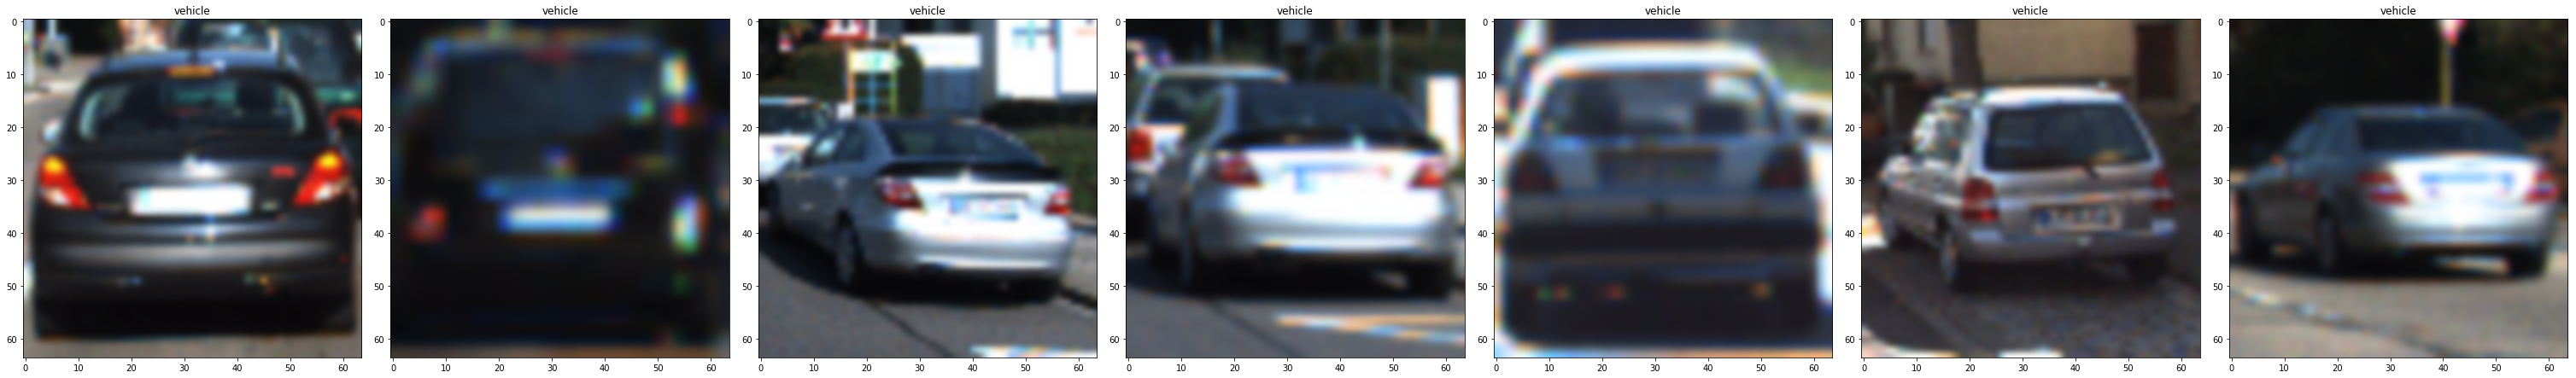

/home/powell/ENTER/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


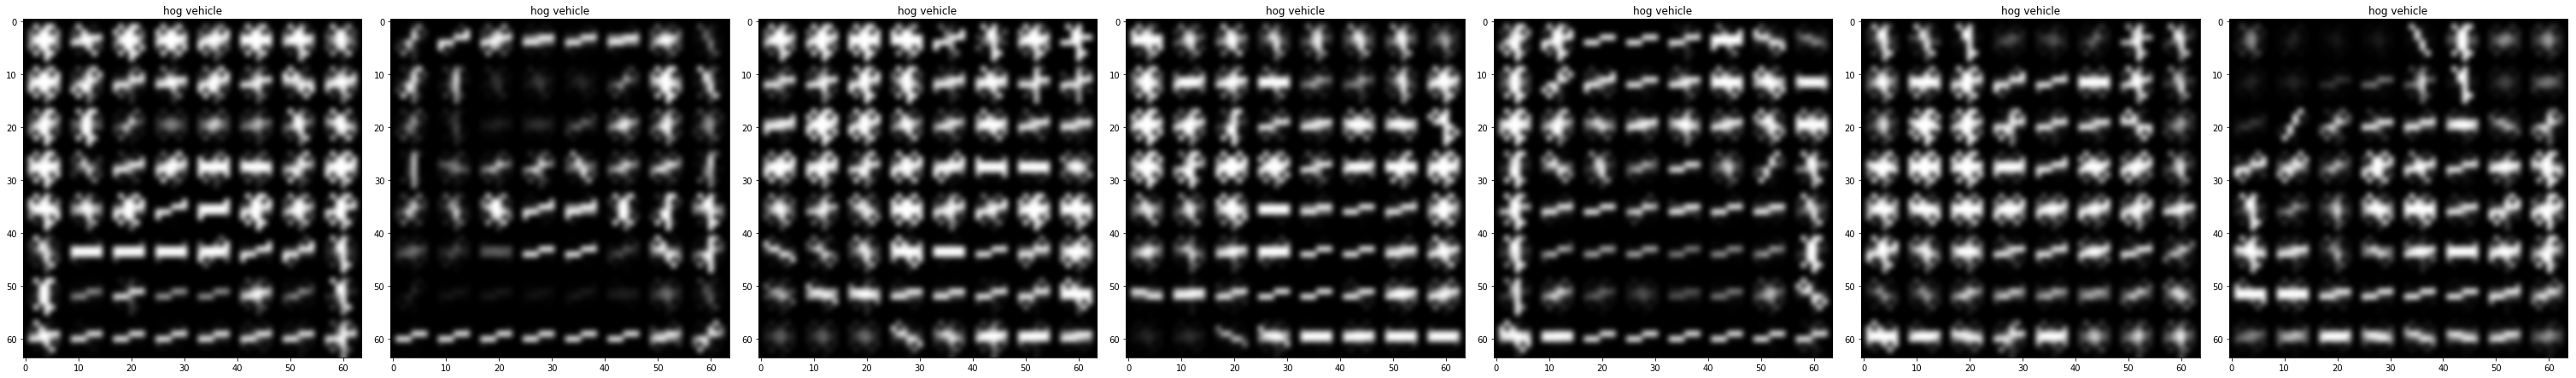

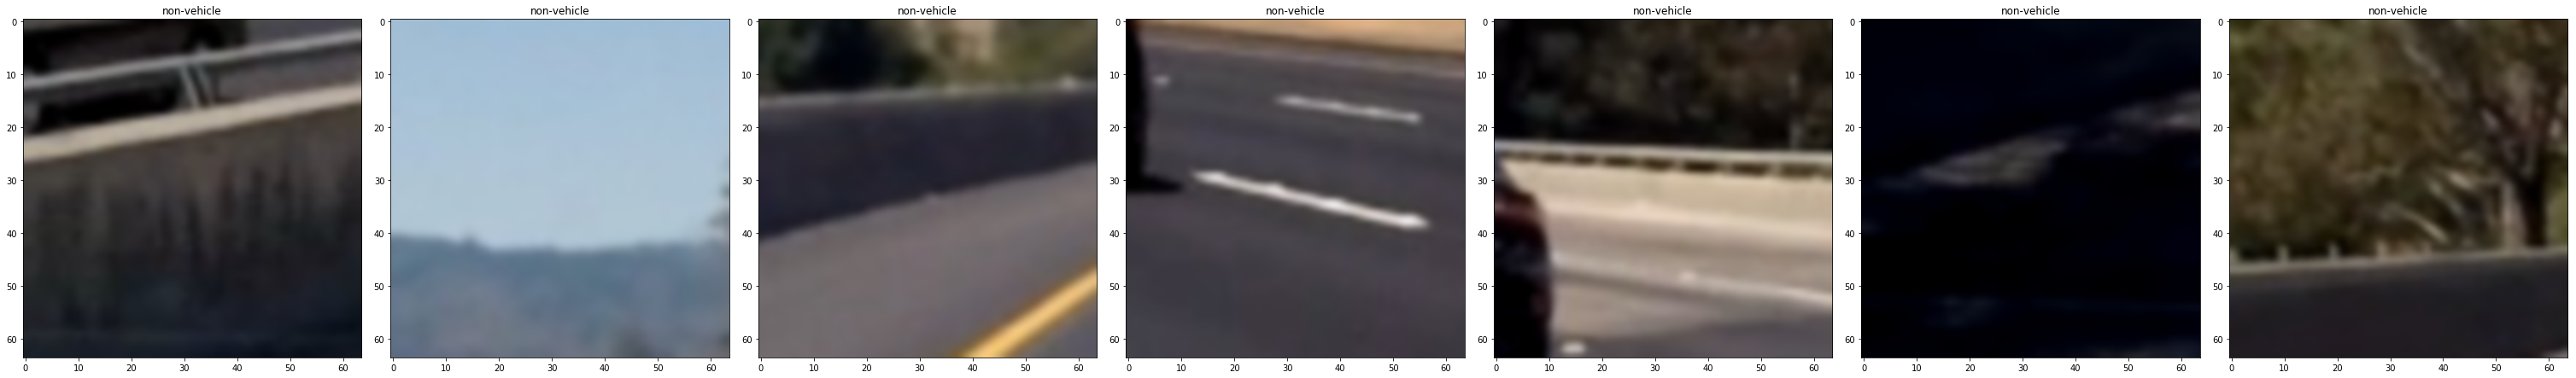

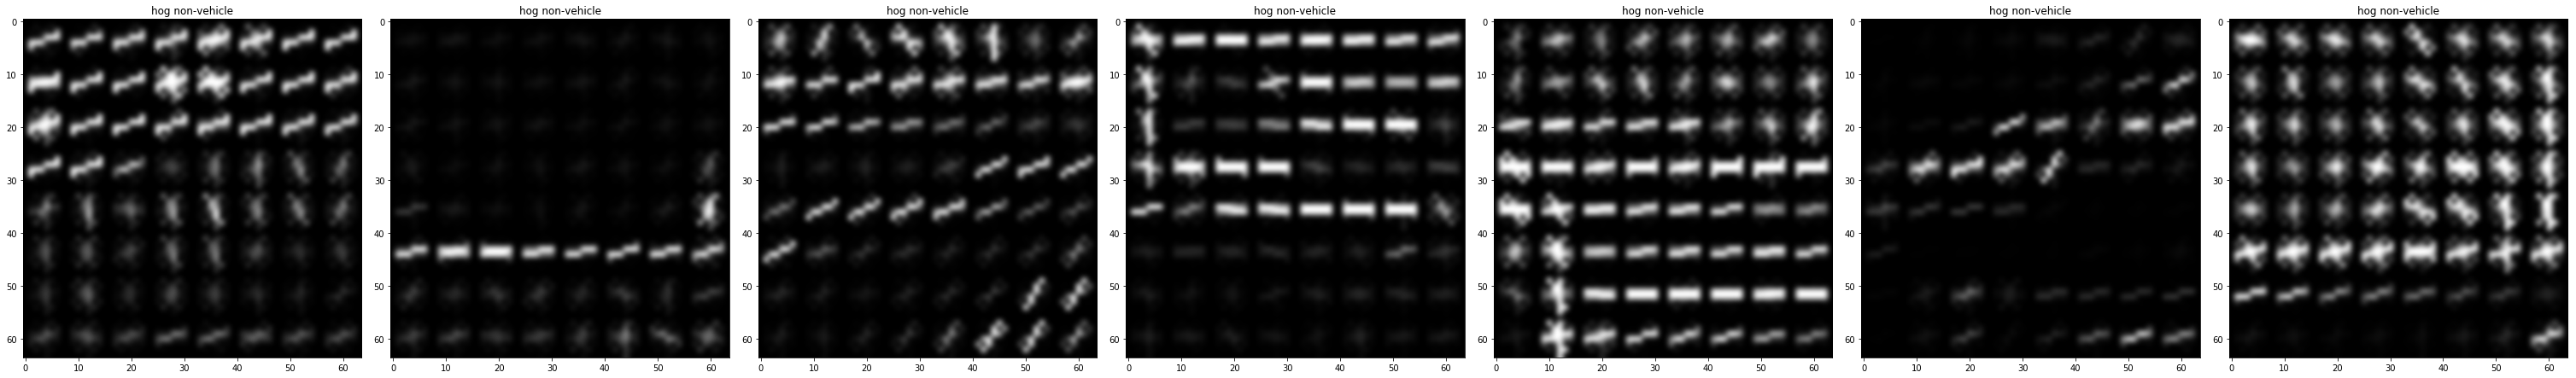

In [113]:
show_images(vehicle_images[1:8], ["vehicle"]*8)
show_images([rescale_intensity(get_hog(x, visualise=True)[1]) for x in vehicle_images[1:8]], ["hog vehicle"]*8)

show_images(non_vehicle_images[1:8], ["non-vehicle"]*8)
show_images([rescale_intensity(get_hog(x, visualise=True)[1]) for x in non_vehicle_images[1:8]], ["hog non-vehicle"]*8)

### Process additional data

### Crop and resize additional data

The additional large data 1 set provided [here](http://bit.ly/udacity-annoations-crowdai) from [self-driving-car/annotations/](https://github.com/udacity/self-driving-car/tree/master/annotations) needs cropping based on
the data in the **labels.csv** file.

Example:
```
xmin,xmax,ymin,ymax,Frame,Label,Preview URL
785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/visualize
89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/visualize
```

In [90]:
#%%pep8

import csv


def process_csv(prefix, fname,
                row_labels=('Frame', 'Label', 'xmin',
                            'xmax', 'ymin', 'ymax')):
    fpath = '{}/{}'.format(prefix, "labels.csv")
    with open(fpath) as csvfile:
        reader = csv.DictReader(csvfile)
        ret = []
        for row in reader:
            v = ['{}/{}'.format(prefix, row['Frame']), row['Label']]
            v.append((int(row['xmin']), int(row['xmax'])))  # xmax is actually ymin
            v.append((int(row['ymin']), int(row['ymax'])))  # ymin is actually xmax
            ret.append(v)
    return ret, row_labels


r, header = process_csv(data_dirs[2], 'labels.csv')

logger.debug(header)
logger.debug(r[0])
logger.debug(r[1])

DEBUG:vd:('Frame', 'Label', 'xmin', 'xmax', 'ymin', 'ymax')
DEBUG:vd:['data/object-detection-crowdai/1479498371963069978.jpg', 'Car', (785, 533), (905, 644)]
DEBUG:vd:['data/object-detection-crowdai/1479498371963069978.jpg', 'Car', (89, 551), (291, 680)]


Number of samples: 72064
Shape of image: (1200, 1920, 3)
Classes: ['Car' 'Pedestrian' 'Truck']


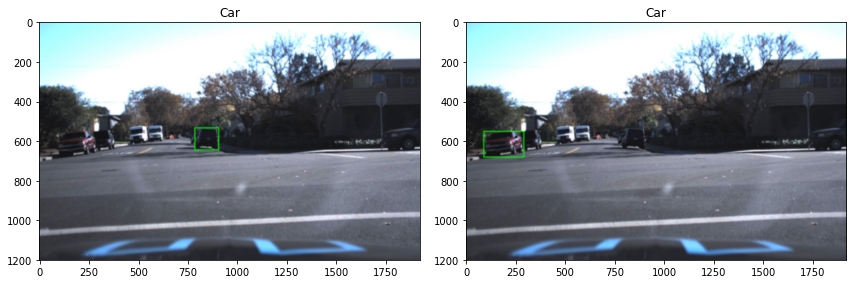

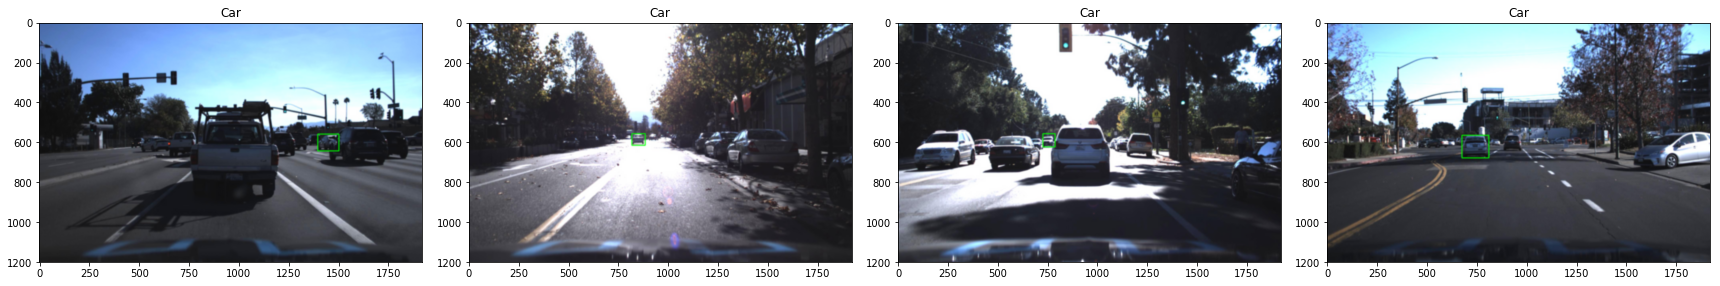

In [104]:
# Show size of the data set
print("Number of samples: {}".format(len(r)))

# Shape of a image
print("Shape of image: {}".format(load_img(r[0][0]).shape))

# Unique classes
print("Classes: {}".format(np.unique([x[1] for x in r])))

# Draw boxes on the first two images.
img_idxs = [ 0, 1 ]

imgs = [ draw_box(r[i][0], r[i][2], r[i][3]) for i in img_idxs ]
imgs_label = [ r[i][1] for i in img_idxs ]

show_images(imgs, imgs_label)

# Pick few random images and draw a rectange around the object
img_idxs = np.random.choice(len(r), 4)
imgs = [ draw_box(r[i][0], r[i][2], r[i][3]) for i in img_idxs ]
imgs_label = [ r[i][1] for i in img_idxs ]

show_images(imgs, imgs_label)